In [2]:
from data.datasets import AbbacusData

abbacus = AbbacusData(datafile='/pscratch/sd/d/dfarough/LSS_data/halo_positions.npy')
abbacus_truth = abbacus.sample()

abbacus_truth.shape

torch.Size([490483, 3])

In [17]:
np.sqrt(3)

np.float64(1.7320508075688772)

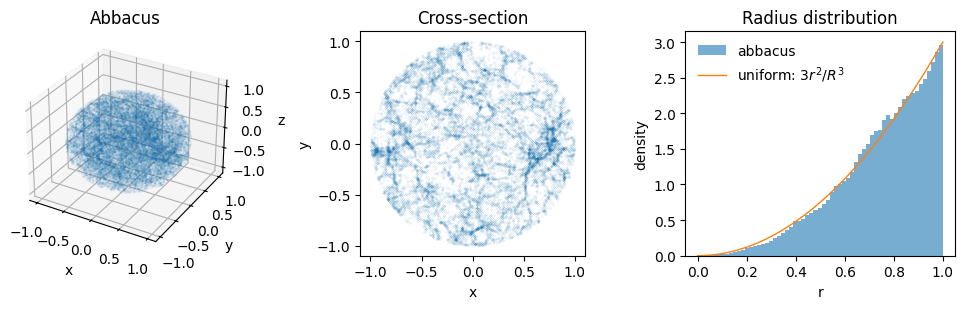

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

x, y, z = abbacus_truth[:,0], abbacus_truth[:,1], abbacus_truth[:,2]
r = torch.linalg.norm(abbacus_truth, dim=1)
N = r.numel()
R = float(r.max())  

fig = plt.figure(figsize=(10, 3.2))

# Abbacus scatter

ax0 = fig.add_subplot(131, projection='3d')
ax0.scatter(x, y, z, s=0.001, alpha=0.1, marker=',')
ax0.set_title("Abbacus")
ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_zlabel("z")

# (x,y) cross-section: thin slab around z=0
ax1 = fig.add_subplot(132)
zabs = z.abs()
slab = 0.05 * R
mask = zabs < slab
ax1.scatter(x[mask], y[mask], s=0.01, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title(f"Cross-section")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# Radius density. For uniform: p(r)=3 r^2 / R^3
ax2 = fig.add_subplot(133)
ax2.hist(r.numpy(), bins=60, density=True, alpha=0.6, label="abbacus")
rho = torch.linspace(0, R, 400)
pdf = 3.0 * (rho**2) / (R**3 + 1e-12)
ax2.plot(rho.numpy(), pdf.numpy(), linewidth=1, label=r"uniform: $3r^2/R^3$")
ax2.set_title("Radius distribution")
ax2.set_xlabel("r")
ax2.set_ylabel("density")
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()



## Two-point correlation function $\xi(r)$ — Landy-Szalay estimator

The gold-standard statistic in LSS analysis. Measures *excess* probability of
finding a pair at separation $r$ relative to a homogeneous Poisson process:

$$\xi(r) = \frac{DD(r) - 2\,DR(r) + RR(r)}{RR(r)}$$

where $DD$, $DR$, $RR$ are normalised pair counts (data–data, data–random,
random–random).  Computed efficiently via `KDTree.count_neighbors`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr


def Landy_Szalay(catalog, N_sub=50_000, n_bins_xi=20):
    """
    Landy-Szalay ξ(r) using TreeCorr (ball-tree with bin_slop approx).
    
    TreeCorr is the standard in observational cosmology (DES, HSC, KiDS).
    Its bin_slop approximation skips pairs clearly inside a bin,
    giving 3-10× speedup over exact KDTree counting.
    
    Parameters
    ----------
    catalog : tensor (N, 3)
    N_sub   : int – subsample size
    n_bins_xi : int – number of radial bins
    """
    N = catalog.shape[0]
    n_sub = min(N_sub, N)
    rng = np.random.default_rng(0)

    idx = rng.choice(N, n_sub, replace=False)
    data_pts = catalog[idx].numpy().astype(np.float64)

    R = float(np.linalg.norm(data_pts, axis=1).max())

    # Random catalog (uniform ball, radius R), 3× the data
    n_rand = 3 * n_sub
    u = rng.normal(size=(n_rand, 3))
    u /= np.linalg.norm(u, axis=1, keepdims=True)
    r_rand = R * rng.random(n_rand) ** (1.0 / 3.0)
    rand_pts = (u * r_rand[:, None]).astype(np.float64)

    # TreeCorr catalogs (3D Cartesian, no RA/Dec)
    cat_D = treecorr.Catalog(x=data_pts[:, 0], y=data_pts[:, 1], z=data_pts[:, 2])
    cat_R = treecorr.Catalog(x=rand_pts[:, 0], y=rand_pts[:, 1], z=rand_pts[:, 2])

    # Configure NNCorrelation for linear bins in 3D separation
    r_min = 1e-6 * R   # small but nonzero to avoid log(0)
    r_max = 2.0 * R
    nn_dd = treecorr.NNCorrelation(min_sep=r_min, max_sep=r_max, nbins=n_bins_xi,
                                    metric='Euclidean', bin_slop=0.1)
    nn_dr = treecorr.NNCorrelation(min_sep=r_min, max_sep=r_max, nbins=n_bins_xi,
                                    metric='Euclidean', bin_slop=0.1)
    nn_rr = treecorr.NNCorrelation(min_sep=r_min, max_sep=r_max, nbins=n_bins_xi,
                                    metric='Euclidean', bin_slop=0.1)

    # Count pairs
    nn_dd.process(cat_D)
    nn_dr.process(cat_D, cat_R)
    nn_rr.process(cat_R)

    # Landy-Szalay via TreeCorr's built-in estimator
    xi, varxi = nn_dd.calculateXi(rr=nn_rr, dr=nn_dr)

    r_centers = np.exp(nn_dd.meanlogr)  # geometric mean of each bin
    return r_centers, xi


def traj_Landy_Szalay(traj, snapshots, N_sub=50_000, bins=20):
    traj_list = [traj[i] for i in snapshots]
    xi_s = []
    for data in traj_list:
        r, xi = Landy_Szalay(data, N_sub=N_sub, n_bins_xi=bins)
        xi_s.append(xi)
    return r, xi_s
        

def plot_trajs(traj, snapshots, figsize=(12, 6),  dpi=120, marker_size=0.01, color='k', marker=',', alpha=1.0, save_fig=None, orientation=(30, -60)):
    N = len(snapshots)
    traj_list = [traj[i].cpu().numpy() for i in snapshots]
    time_steps = [round(float(x)/snapshots[-1],2) for x in snapshots]
    elev, azim = orientation
    fig = plt.figure(figsize=figsize, dpi=dpi)
    for i, data in enumerate(traj_list):
        ax = fig.add_subplot(1, N, i+1, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        ax.grid(False)
        ax.set_title(f't={time_steps[i]}')        

        ax.scatter3D(data[:,0], data[:,1], data[:,2], s=marker_size, c=color, marker=marker, alpha=alpha)
        
        # Draw full cube
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        zlim = ax.get_zlim()
        
        # Construct corners
        corners = np.array([
            [xlim[0], ylim[0], zlim[0]],
            [xlim[1], ylim[0], zlim[0]],
            [xlim[1], ylim[1], zlim[0]],
            [xlim[0], ylim[1], zlim[0]],
            [xlim[0], ylim[0], zlim[1]],
            [xlim[1], ylim[0], zlim[1]],
            [xlim[1], ylim[1], zlim[1]],
            [xlim[0], ylim[1], zlim[1]]
        ])
        
        # Edges
        edges = [
            (0,1), (1,2), (2,3), (3,0), # Bottom
            (4,5), (5,6), (6,7), (7,4), # Top
            (0,4), (1,5), (2,6), (3,7)  # Vertical
        ]
        
        for start, end in edges:
            ax.plot3D(
                [corners[start,0], corners[end,0]],
                [corners[start,1], corners[end,1]],
                [corners[start,2], corners[end,2]],
                'k--', linewidth=0.5
            )
        
        ax.set_axis_off()

    if save_fig is not None:
        plt.savefig(save_fig, dpi=dpi)
        
    plt.show()
    plt.close()


## Results

In [5]:
import torch
from pathlib import Path

from utils import BASE_DIR, PROJECT
from data.datasets import AbbacusData, Uniform3D
from utils.plotting import plot_lss_slices, plot_lss_results

exp_id = 'a5ee61bc36d3419384e4dc3346a21fb6'
exp_dir = Path(BASE_DIR, PROJECT, exp_id)
traj = torch.load(exp_dir / "trajectories.pt")

abbacus = AbbacusData(datafile='/pscratch/sd/d/dfarough/LSS_data/halo_positions.npy')
truth = abbacus.sample()
r, xi_abbacus = Landy_Szalay(truth, N_sub=100_000, n_bins_xi=100)

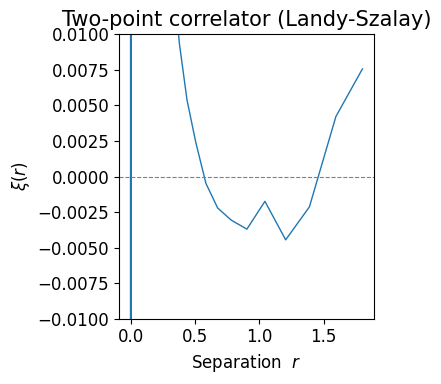

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(r, xi_abbacus, lw=1, label=r"$\xi(r)$ Landy-Szalay")
ax.axhline(0, color='grey', ls='--', lw=0.8)
ax.set_xlabel("$r$")
ax.set_ylabel(r"$\xi(r)$")
ax.set_title("2-point correlator (Landy-Szalay)", footnote=12)
ax.set_ylim(-0.01,.01)
plt.tight_layout()
plt.show()

In [ ]:


def traj_Landy(traj, snapshots, N_sub=15_000, bins=20):
    N = len(snapshots)
    traj_list = [traj[i] for i in snapshots]
    xi_s = []
    for i, data in enumerate(traj_list):
        r, xi = Landy_Szalay(data, N_sub=N_sub, n_bins_xi=bins)
        xi_s.append(xi)
    return r, xi_s
        

def plot_trajs(traj, snapshot_list, figsize=(12, 6),  dpi=120, marker_size=0.01, color='k', marker=',', alpha=1.0, save_fig=None, orientation=(30, -60)):
    N = len(snapshot_list)
    traj_list = [traj[i].cpu().numpy() for i in snapshot_list]
    time_steps = [round(float(x)/snapshot_list[-1],2) for x in snapshot_list]
    elev, azim = orientation
    fig = plt.figure(figsize=figsize, dpi=dpi)
    for i, data in enumerate(traj_list):
        ax = fig.add_subplot(1, N, i+1, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        ax.grid(False)
        ax.set_title(f't={time_steps[i]}')        

        ax.scatter3D(data[:,0], data[:,1], data[:,2], s=marker_size, c=color, marker=marker, alpha=alpha)
        
        # Draw full cube
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        zlim = ax.get_zlim()
        
        # Construct corners
        corners = np.array([
            [xlim[0], ylim[0], zlim[0]],
            [xlim[1], ylim[0], zlim[0]],
            [xlim[1], ylim[1], zlim[0]],
            [xlim[0], ylim[1], zlim[0]],
            [xlim[0], ylim[0], zlim[1]],
            [xlim[1], ylim[0], zlim[1]],
            [xlim[1], ylim[1], zlim[1]],
            [xlim[0], ylim[1], zlim[1]]
        ])
        
        # Edges
        edges = [
            (0,1), (1,2), (2,3), (3,0), # Bottom
            (4,5), (5,6), (6,7), (7,4), # Top
            (0,4), (1,5), (2,6), (3,7)  # Vertical
        ]
        
        for start, end in edges:
            ax.plot3D(
                [corners[start,0], corners[end,0]],
                [corners[start,1], corners[end,1]],
                [corners[start,2], corners[end,2]],
                'k--', linewidth=0.5
            )
        
        ax.set_axis_off()

    if save_fig is not None:
        plt.savefig(save_fig, dpi=dpi)
        
    plt.show()
    plt.close()

In [9]:
snapshots = [0,16,32,48,64,80,96,112,128]
r, xis = traj_Landy(traj, snapshots, N_sub=100_000, bins=100)

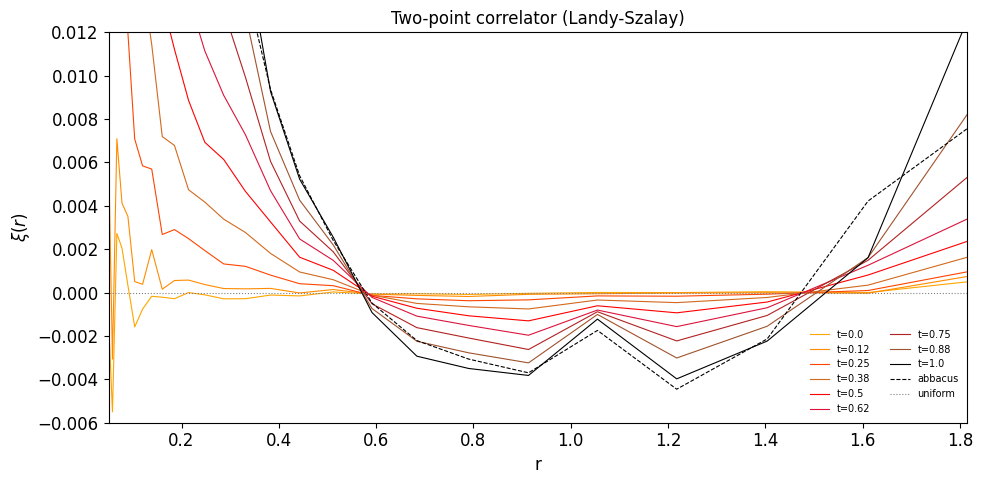

In [18]:

traj_list = [traj[i] for i in snapshots]
time_steps = [round(float(x)/snapshots[-1],2) for x in snapshots]
fig, ax = plt.subplots(figsize=(10,5))
colors = ['k', 'sienna', 'firebrick', 'crimson', 'r','chocolate','orangered', 'darkorange', 'orange'][::-1]
for i, data in enumerate(traj_list):
    ax.plot(r, xis[i], lw=0.8, color=colors[i], label=f't={time_steps[i]}')
ax.plot(r, xi_abbacus, lw=0.8, color='k', ls='--', label=f'abbacus')
ax.set_title("Two-point correlator (Landy-Szalay)", fontsize=12)
ax.axhline(0, color='grey', ls=':', lw=0.8, label='uniform')
ax.legend(frameon=False, fontsize=7, ncol=2)
ax.set_ylim(-0.006,0.012)
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi(r)$')
# log x
# ax.set_xscale('log')
ax.set_xlim(0.05, r[-1])
plt.tight_layout()
plt.show()
plt.close()

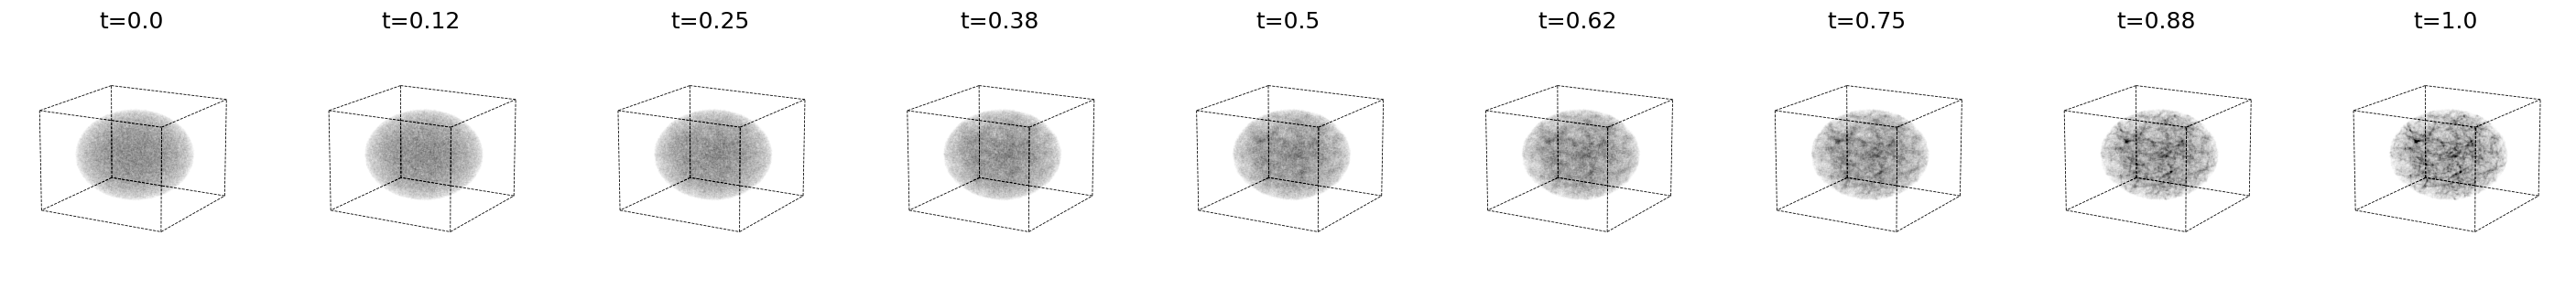

In [8]:
snapshots = [0,16,32,48,64,80,96,112,128]
plot_trajs(traj, snapshots, marker=',', marker_size=0.04, alpha=0.005,  figsize=(30,5), save_fig= exp_dir / "abbacus_traj.png", orientation=(15,30))


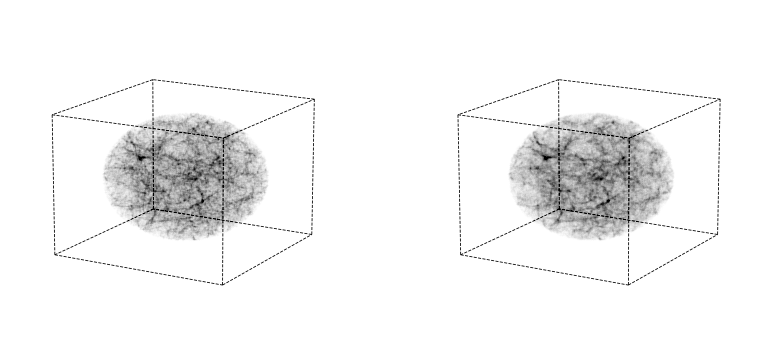

In [7]:
plot_lss_results(truth, traj[-1], marker=',', marker_size=0.1, alpha=0.005, colors=['k','k'],figsize=(8,4), save_fig= exp_dir / "abbacus_traj.png", orientation=(15,30))


In [7]:
import numpy as np  


def compute_power_spectrum_cube(points, box_size, grid_size):
    """
    Compute an approximate 3D power spectrum P(k) from a point cloud
    living inside a cubic box with periodic boundary conditions.

    Parameters
    ----------
    points : array_like, shape (N, 3)
        Galaxy positions in R^3, assumed to be in [-box_size/2, box_size/2) for each dimension.
    box_size : float
        Physical size of the cubic box.
    grid_size : int
        Number of grid cells per dimension for the voxel grid (e.g. 128 or 256).

    Returns
    -------
    k_vals : 1D ndarray
        Bin centers in k-space.
    Pk : 1D ndarray
        Spherically averaged power spectrum P(k) for each bin.
    """

    points = np.asarray(points, dtype=np.float32)


    # Grid spacing
    dx = box_size / grid_size

    # Cloud-in-cell assignment of points to a 3D grid
    density = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    coords = points / dx  # convert to grid coordinates in [0, grid_size)

    for x, y, z in coords:
        i = int(np.floor(x)) % grid_size
        j = int(np.floor(y)) % grid_size
        k = int(np.floor(z)) % grid_size

        dx1 = x - i
        dy1 = y - j
        dz1 = z - k

        dx0 = 1.0 - dx1
        dy0 = 1.0 - dy1
        dz0 = 1.0 - dz1

        # Distribute mass to 8 neighbors (periodic boundary conditions)
        density[i,                   j,                   k                  ] += dx0 * dy0 * dz0
        density[(i + 1) % grid_size, j,                   k                  ] += dx1 * dy0 * dz0
        density[i,                   (j + 1) % grid_size, k                  ] += dx0 * dy1 * dz0
        density[i,                   j,                   (k + 1) % grid_size] += dx0 * dy0 * dz1
        density[(i + 1) % grid_size, (j + 1) % grid_size, k                  ] += dx1 * dy1 * dz0
        density[(i + 1) % grid_size, j,                   (k + 1) % grid_size] += dx1 * dy0 * dz1
        density[i,                   (j + 1) % grid_size, (k + 1) % grid_size] += dx0 * dy1 * dz1
        density[(i + 1) % grid_size, (j + 1) % grid_size, (k + 1) % grid_size] += dx1 * dy1 * dz1

    # Compute overdensity field δ = ρ / <ρ> - 1
    density_mean = np.mean(density)
    
    if density_mean == 0:
        raise ValueError("Mean density is zero; check input points / grid_size.")

    delta = density / density_mean - 1.0

    # FFT and power spectrum
    delta_k = np.fft.fftn(delta)
    delta_k = np.fft.fftshift(delta_k)
    power = np.abs(delta_k) ** 2

    # Construct k-grid and bin isotropically
    kfreq = np.fft.fftfreq(grid_size, d=dx)
    kfreq = np.fft.fftshift(kfreq)

    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    kk = np.sqrt(kx**2 + ky**2 + kz**2)

    k_flat = kk.ravel()
    p_flat = power.ravel()

    # Ignore k=0 mode
    nonzero = k_flat > 0
    k_flat = k_flat[nonzero]
    p_flat = p_flat[nonzero]

    # Bin in k (log-space)
    kmin = k_flat.min()
    kmax = k_flat.max()
    nbins = grid_size // 2

    k_edges = np.logspace(np.log10(kmin), np.log10(kmax), nbins + 1)
    bin_idx = np.digitize(k_flat, k_edges)

    k_vals = np.zeros(nbins)
    Pk = np.zeros(nbins)

    for b in range(1, nbins + 1):
        mask_b = bin_idx == b
        if np.any(mask_b):
            k_vals[b - 1] = np.mean(k_flat[mask_b])
            Pk[b - 1] = np.mean(p_flat[mask_b])
        else:
            k_vals[b - 1] = np.nan
            Pk[b - 1] = np.nan

    valid = ~np.isnan(Pk)
    return k_vals[valid], Pk[valid]



# Compute power spectrum for points in a cubic box
k_vals, Pk_truth = compute_power_spectrum_cube(truth, box_size=voxel_size, grid_size=128)
k_vals, Pk_gen = compute_power_spectrum_cube(gen_sample, box_size=voxel_size, grid_size=128)

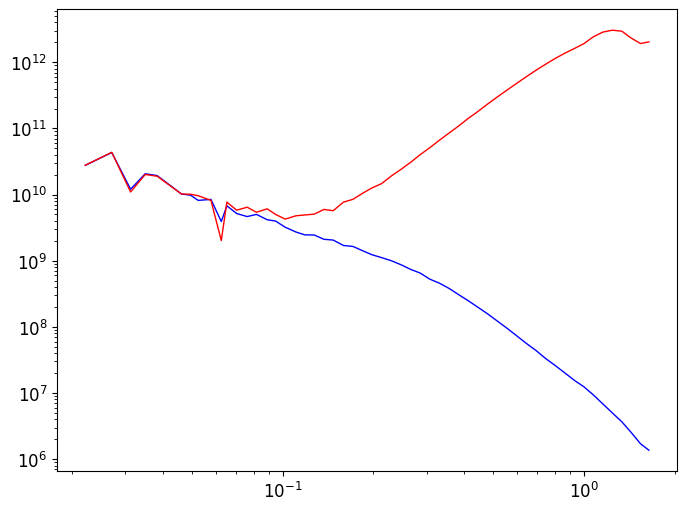

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

# --- top panel ---
ax.loglog(k_vals, Pk_truth, label='truth', c='b', lw=1.)
ax.loglog(k_vals, Pk_gen, label='gen', c='r', lw=1.)
plt.show()

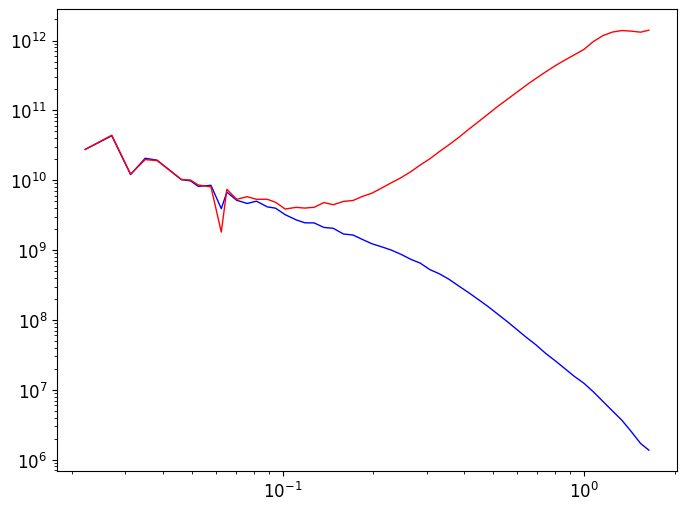

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

# --- top panel ---
ax.loglog(k_vals, Pk_truth, label='truth', c='b', lw=1.)
ax.loglog(k_vals, Pk_gen, label='gen', c='r', lw=1.)
plt.show()

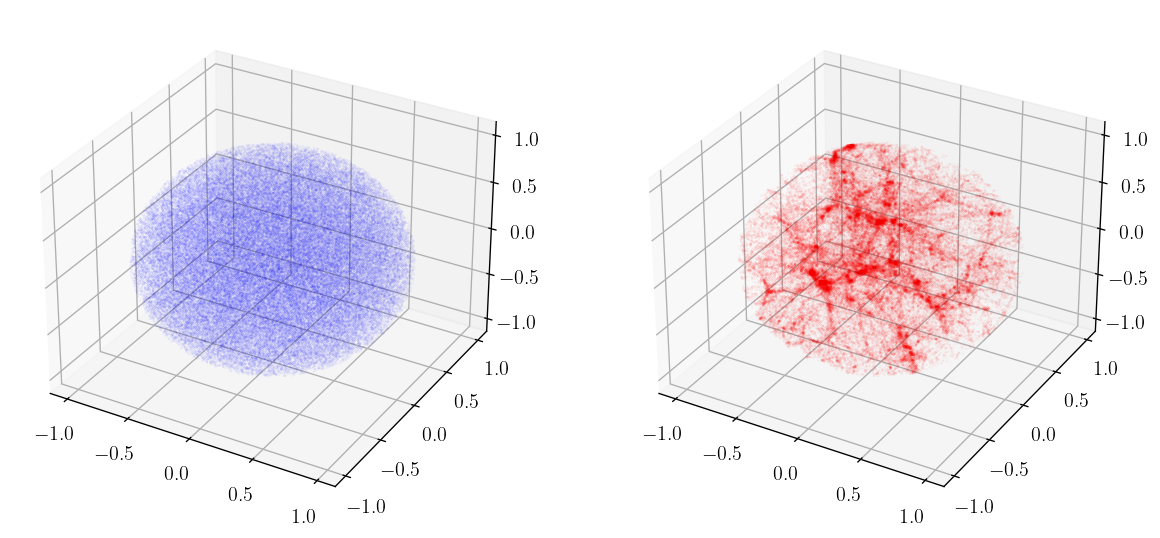

In [22]:
from utils import plot_lss_results

plot_lss_results(source_data, target_data, marker_size=0.001, alpha=0.5)

In [ ]:
import pytorch_lightning as L
from torch.utils.data import DataLoader
from cfm import ConditionalFlowMatching

from dataclasses import dataclass
from datasets import SphericalUniform, UchuuCentered, DataCoupling

#==================

@dataclass
class Config:
    exp_id = '4ccbb17faf71430d8be0ce5f33706c6e'
    ckpt = 'last'
    num_points = 100_000
    dim = 3
    dim_fourier = 256
    n_embd = 512
    num_blocks = 6
    dropout = 0.1
    sigma = 1e-4 # cfm hyperparameter
    flow = 'uniform'
    gamma = 1.0  # fourier feature hyperparameter
    batch_size = 1024
    mass_reg = 0.25
    use_mass_reg = True
    use_OT = True
    num_steps = 200

config = Config()

uniform_density = SphericalUniform(radius=1)
source_data = uniform_density.sample(num_points=config.num_points)

dataset = DataCoupling(source=source_data, target=None)
gen_dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)              

base_dir = '/home/df630/LargeScaleStructureFlows/Results/LargeScaleStructure/'
model = ConditionalFlowMatching.load_from_checkpoint(base_dir + config.exp_id +f'/checkpoints/{config.ckpt}.ckpt',  map_location="cpu", config=config)

trainer = L.Trainer(accelerator='gpu', devices=[0], inference_mode=False)
sample_batched = trainer.predict(model, gen_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/gaia_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/df630/.conda/envs/gaia_env/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [4]:
import torch

trajectories = torch.cat(sample_batched, dim=0)  # (N, num_timesteps, 3) 
trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
trajectories = trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
gen_sample = trajectories[-1]

torch.save(gen_sample, base_dir + config.exp_id + '/gen_sample.pt')

In [30]:
gen_sample.shape

torch.Size([100000, 3])

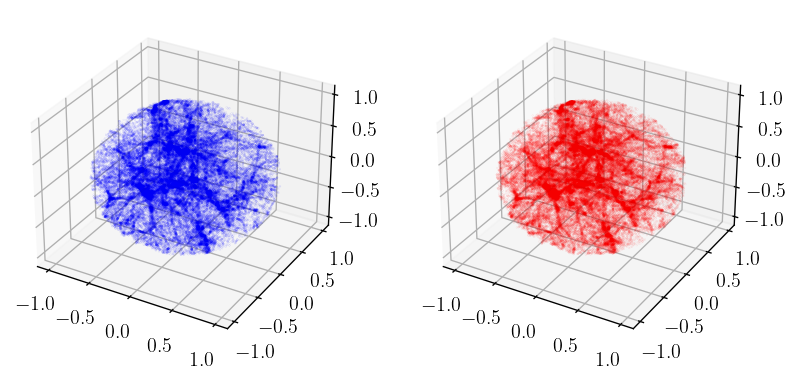

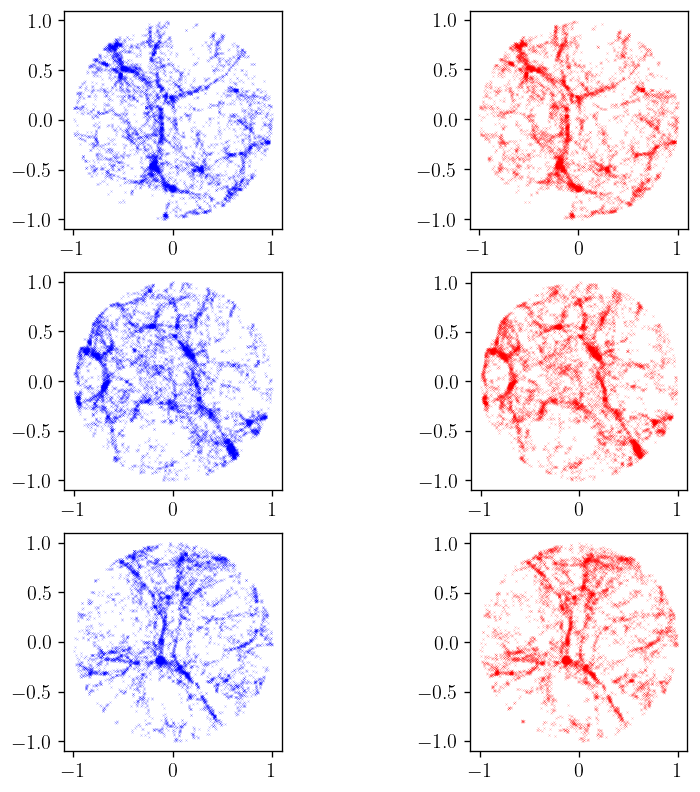

In [31]:
import matplotlib.pyplot as plt

from utils import plot_lss_results, plot_lss_slices

plot_lss_results(target_data[:100000], gen_sample, marker_size=0.001, alpha=0.75, figsize=(8,8))
plot_lss_slices(target_data[:100000], gen_sample, marker_size=0.002, figsize=(8,8), alpha=1,marker='x')


In [6]:
from utils import compute_power_spectrum_sphere, plot_power_spectrum_sphere

k, Pk_gen = compute_power_spectrum_sphere(gen_sample, grid_size=512)


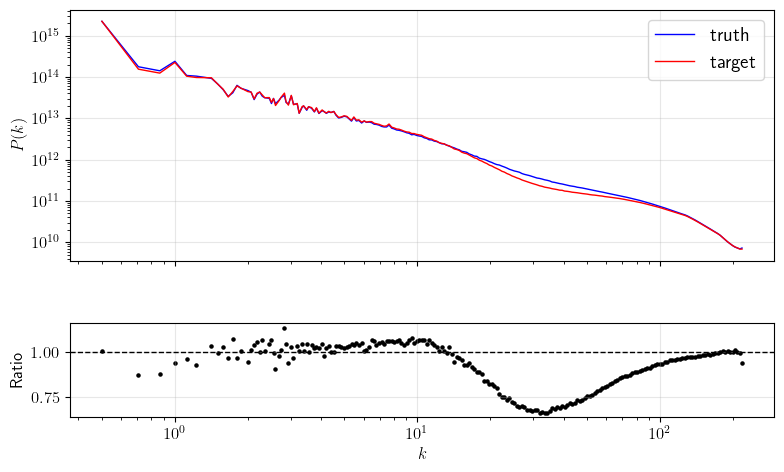

In [25]:
plot_power_spectrum_sphere(k, Pk_target, Pk_gen)

## Free-Fall Flow

In [9]:
import pytorch_lightning as L
from torch.utils.data import DataLoader
from cfm import ConditionalFlowMatching

from dataclasses import dataclass
from datasets import SphericalUniform, UchuuCentered, DataCoupling

#==================

@dataclass
class Config:
    exp_id = 'c5a2d062efde43b0a0383bffbecd86c9'
    ckpt = 'best'
    num_points = 100_000
    dim = 3
    dim_fourier = 256
    n_embd = 512
    num_blocks = 6
    dropout = 0.1
    sigma = 1e-4 # cfm hyperparameter
    flow = 'freefall'
    gamma = 1.0  # fourier feature hyperparameter
    batch_size = 1024
    mass_reg = 0.25
    use_mass_reg = True
    use_OT = True
    num_steps = 200

config = Config()

uniform_density = SphericalUniform(radius=1)
source_data = uniform_density.sample(num_points=config.num_points)

dataset = DataCoupling(source=source_data, target=None)
gen_dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)              

base_dir = '/home/df630/LargeScaleStructureFlows/Results/LargeScaleStructure/'
model = ConditionalFlowMatching.load_from_checkpoint(base_dir + config.exp_id +f'/checkpoints/{config.ckpt}.ckpt',  map_location="cpu", config=config)

trainer = L.Trainer(accelerator='gpu', devices=[0], inference_mode=False)
sample_batched = trainer.predict(model, gen_dataloader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/gaia_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
import torch

trajectories = torch.cat(sample_batched, dim=0)  # (N, num_timesteps, 3) 
trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
trajectories = trajectories.permute(1,0,2)  # (num_timesteps, N, 3)
gen_sample_freefall = trajectories[-1]

torch.save(gen_sample_freefall, base_dir + config.exp_id + '/gen_sample.pt')

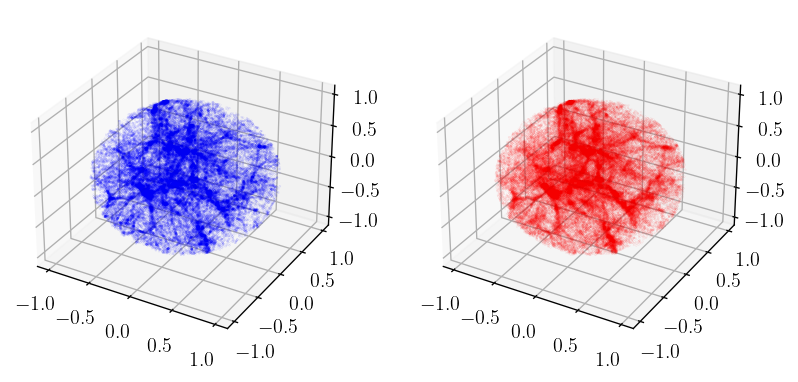

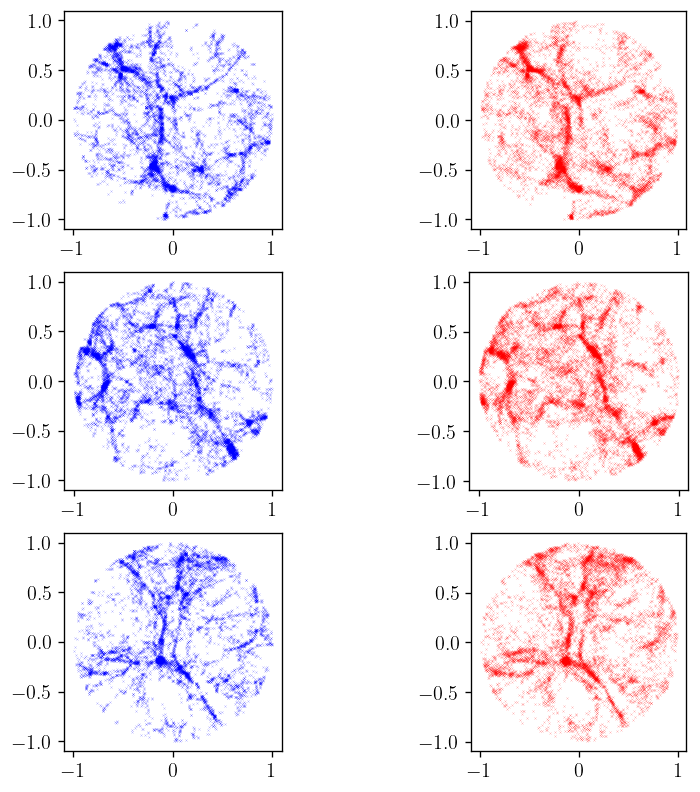

In [14]:
plot_lss_results(target_data, gen_sample_freefall, marker_size=0.001, alpha=0.75, figsize=(8,8))
plot_lss_slices(target_data, gen_sample_freefall, marker_size=0.002, figsize=(8,8), alpha=1,marker='x')

In [12]:
k, Pk_gen_freefall = compute_power_spectrum_sphere(gen_sample_freefall, grid_size=512)

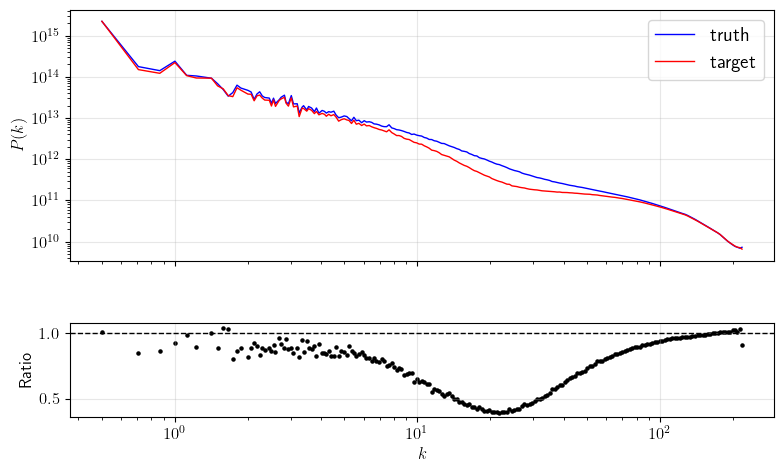

In [28]:
from utils import compute_power_spectrum_sphere, plot_power_spectrum_sphere

plot_power_spectrum_sphere(k, Pk_target, Pk_gen_freefall)

In [27]:
gen_sample_freefall.shape

torch.Size([100000, 3])